In [1]:
from astropy.io import fits
import astropy.stats
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import csv
import logging
import asyncio
import pandas as pd
from astropy.io import fits
from astropy.time import Time
from scipy import interpolate
from matplotlib.pyplot import cm

from lsst_efd_client import EfdClient

from lsst.ts import salobj

In [5]:
plt.rcParams.update({'font.size': 14, 'font.family':'serif'})

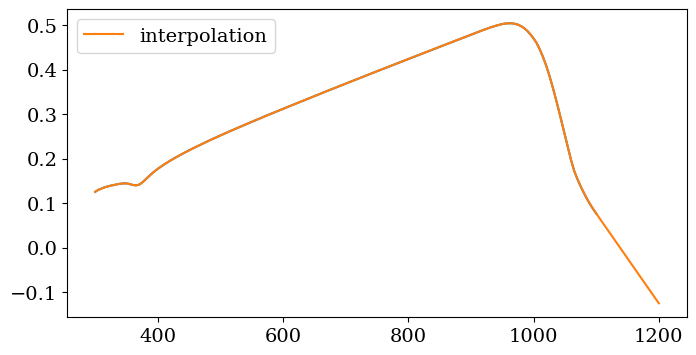

In [26]:
df = pd.read_csv('../hamamatsu_responsivity.csv')


f = interpolate.interp1d(list(df.wavelength), list(df.responsivity),bounds_error=False, fill_value='extrapolate')
plt.figure(figsize=(8,4))
plt.plot(df.wavelength, df.responsivity)
xx = np.linspace(300, 1200, 1200-300)
plt.plot(xx, f(xx), label='interpolation')
plt.legend()
def watts_per_mm2(amps,wl):
    area = 10**2 #10mm^2
    watts = amps/f(wl)
    watts_per_mm2 = watts/area
    return watts_per_mm2

## Test 0: Spectral Lamp

In [38]:
hdu = fits.open('/home/parfa30/DATA/AuxTel/spectral_lamp-2022-09-06T22:26:02.021.fits')#_2022-06-23T18:57:28.398.fits')

Text(0.5, 1.0, 'Spectrum of Avantes Spectral Lamp')

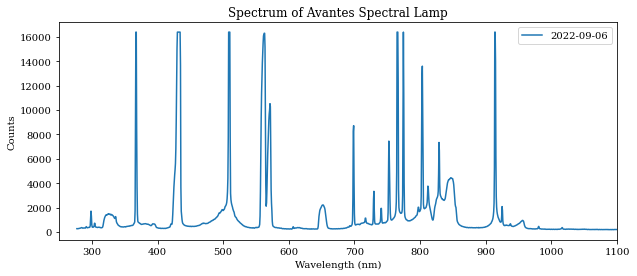

In [39]:
plt.figure(figsize=(10,4))
plt.plot(hdu[1].data['wavelength'].flatten(), hdu[0].data, label='2022-09-06')
plt.xlim(250,1100)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Counts')
plt.legend()
plt.title('Spectrum of Avantes Spectral Lamp')

Text(0.5, 1.0, 'Spectrum of Avantes Spectral Lamp')

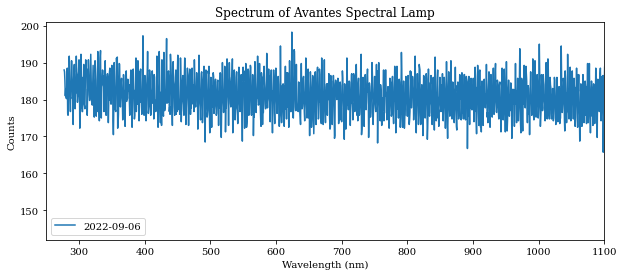

In [30]:
plt.figure(figsize=(10,4))
plt.plot(hdu[1].data['wavelength'].flatten(), hdu[0].data, label='2022-09-06')
plt.xlim(250,1100)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Counts')
plt.legend()
plt.title('Spectrum of Avantes Spectral Lamp')

In [34]:
avantes_lines = [253.65, 265.2,265.37, 275.28, 289.36, 296.73, 302.15, 312.57, 334.15, 
                 365.01, 404.66, 407.78, 434.75, 435.83, 546.08, 576.96, 579.07, 696.54, 706.72,
                 727.29, 738.4, 763.51, 772.4, 794.82, 800.62, 811.53, 842.45, 852.14, 912.3, 922.45]

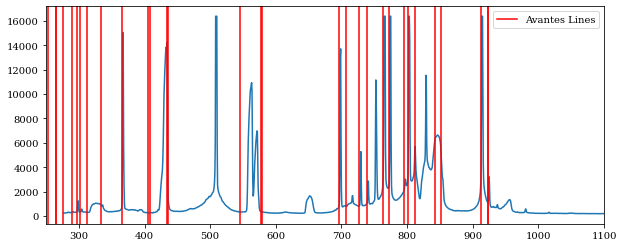

In [35]:
plt.figure(figsize=(10,4))
plt.plot(hdu[1].data['wavelength'].flatten(), hdu[0].data)
plt.xlim(250,1100)
for line in avantes_lines:
    plt.axvline(line,color='r')
plt.axvline(avantes_lines[-1],color='r', label='Avantes Lines')
plt.legend()
#plt.xlim(800,900)

To Do:

- Measure location of measured lines and compare to Avantes values. Is it just one value (2mm?)
- Where are the other lines coming from? (i.e. those not published in the lamp)

## Test 1: Slit Width

In [31]:
df = pd.read_csv('/home/parfa30/DATA/AT_slitwidth_vs_wave_500.csv')

In [32]:
def plot_slit_width(filen_base, max_):
    fig, axarr = plt.subplots(5,2, figsize=(15,15))
    ax = axarr.ravel()
    for grating in [0, 1]:
        filen = '{}_grating{}_1000W_broad.fits'.format(filen_base, grating)
        info = filen.split('_')
        power = info[-1].split('.')[0]
        hdu = fits.open(filen)
        
        data = hdu['CONFIG'].data
        center_wave = np.unique(data.wavelength)
        wave = [float(x[0]) for x in hdu['WAVELENGTH'].data]

        colors = ['C{}'.format(c) for c in range(10)]
        for i, exit in enumerate(np.unique(data['exit'])):
            idx = np.where(data['exit'] == exit)
            for iii, ii in enumerate(idx[0]):
                d = data[ii]
                if grating ==0:
                    ax[i].plot(wave, hdu['SPECTRO'].data[ii], color=colors[iii], label = '{:.2f}'.format(d['entry']))
                elif grating ==1:
                    ax[i].plot(wave, hdu['SPECTRO'].data[ii], '--',color=colors[iii])
                ax[i].set_title('Exit slit width: {:.2f}'.format(exit))
                ax[i].set_xlim(center_wave-20, center_wave+20)
                ax[i].set_ylabel("Counts")
                ax[i].set_ylim(150, int(max_))
                if i >5:
                    ax[i].set_xlabel("Wavelength (nm)")

                ax[i].legend()
        fig.suptitle('{}, {}'.format(int(center_wave[0]),power))
        #plt.legend(loc=right)


In [33]:
files = np.array([['/home/parfa30/DATA/AuxTel/slit_vs_wave_300nm',300],
         ['/home/parfa30/DATA/AuxTel/slit_vs_wave_400nm',1000],
         ['/home/parfa30/DATA/AuxTel/slit_vs_wave_500nm',1000],
         ['/home/parfa30/DATA/AuxTel/slit_vs_wave_600nm',1000],
         ['/home/parfa30/DATA/AuxTel/slit_vs_wave_700nm',1000],
         ['/home/parfa30/DATA/AuxTel/slit_vs_wave_800nm',1000],
         ['/home/parfa30/DATA/AuxTel/slit_vs_wave_900nm',1000],
         ['/home/parfa30/DATA/AuxTel/slit_vs_wave_1000nm',300]]),#,
         #'/home/parfa30/DATA/AuxTel/slit_vs_wave_1100nm_grating1_900W.fits']

In [5]:
300, 0, .1, .04
400, 0, .1, .04
500, 0, .1, .04
600, 0, .1, .04
700, 0, .1, .04
800, 1, .1, .04
900, 1, .1, .04
1000, 1, .5, .04

(1000, 1, 0.5, 0.04)

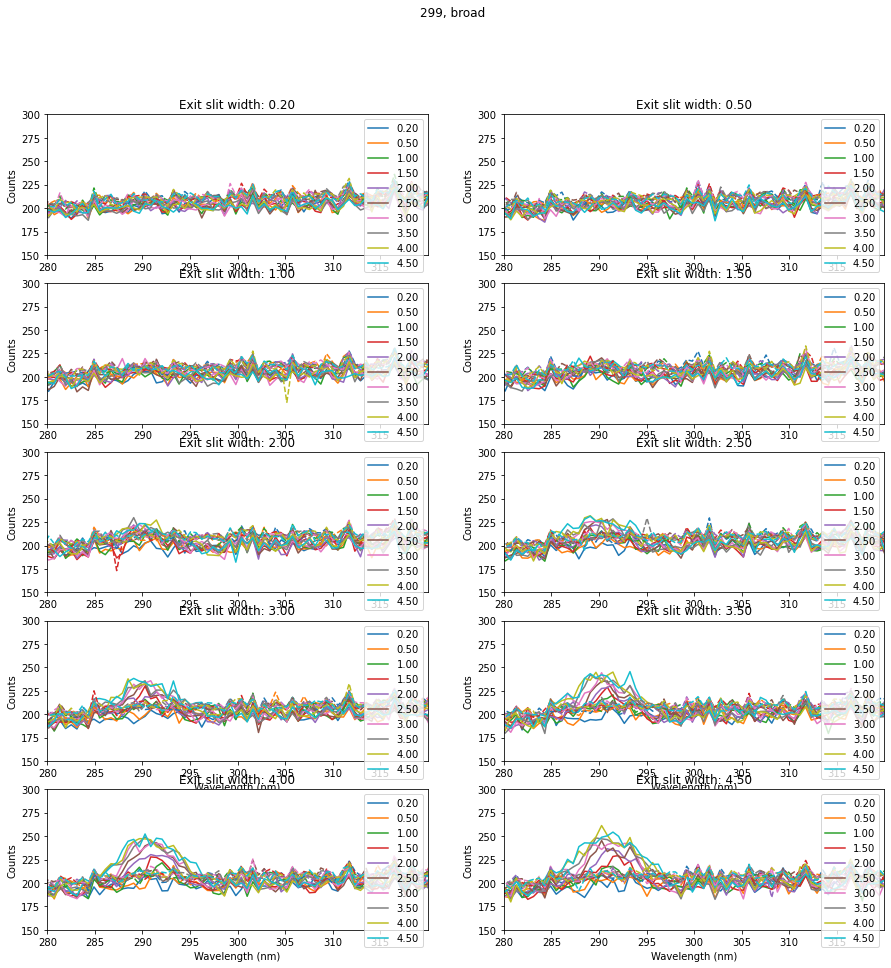

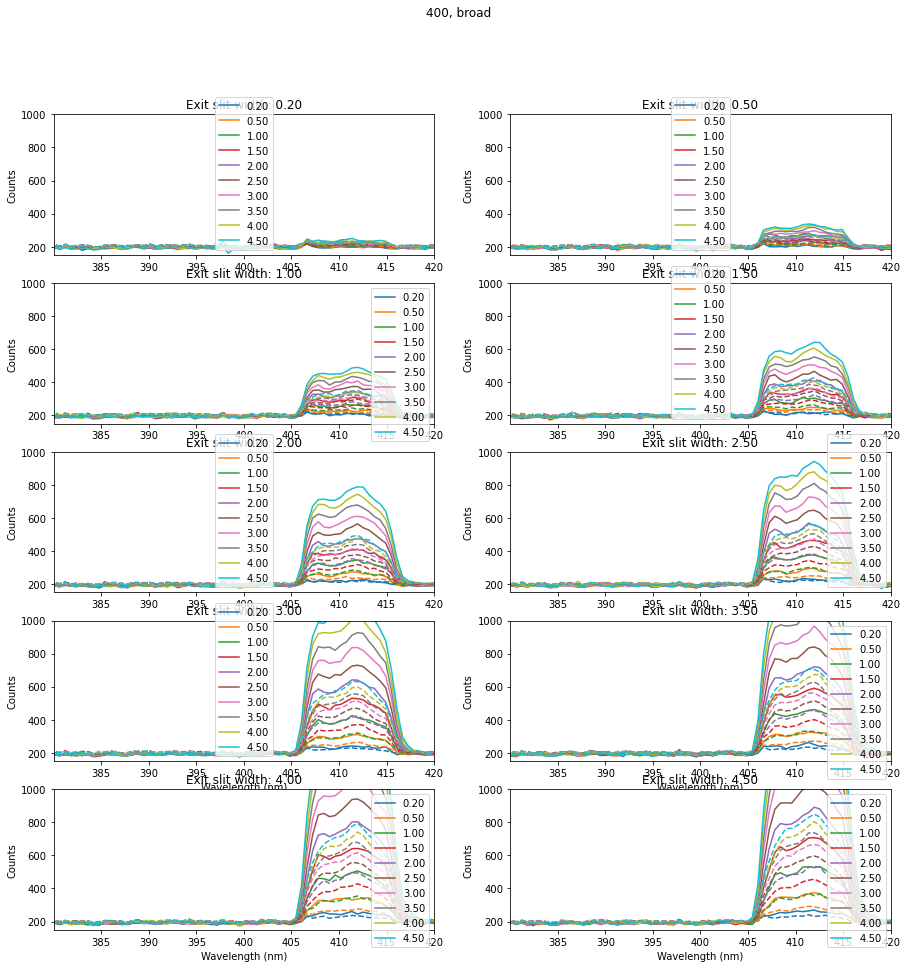

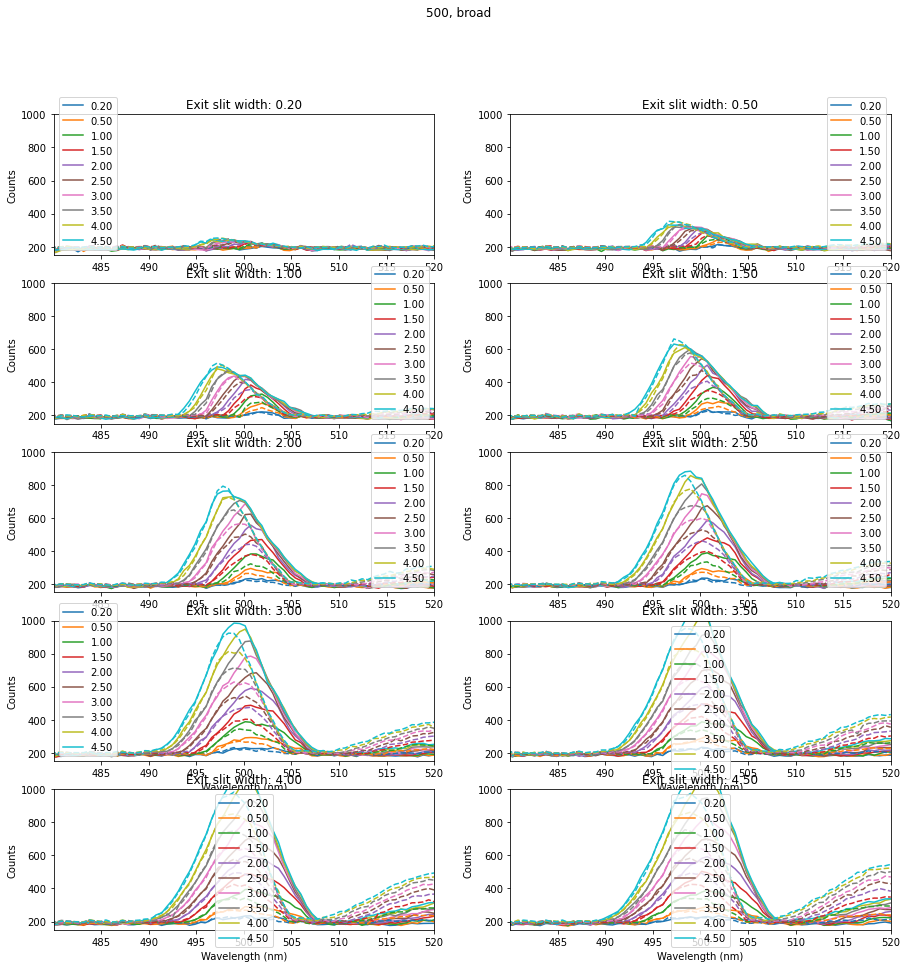

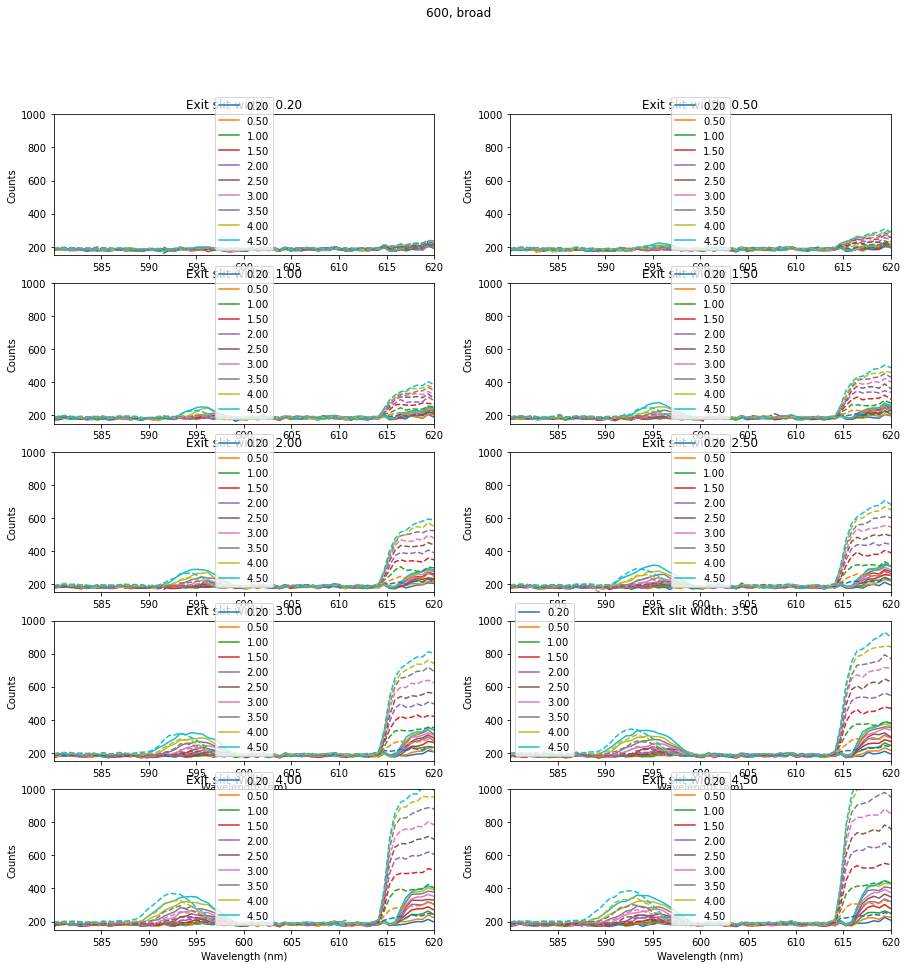

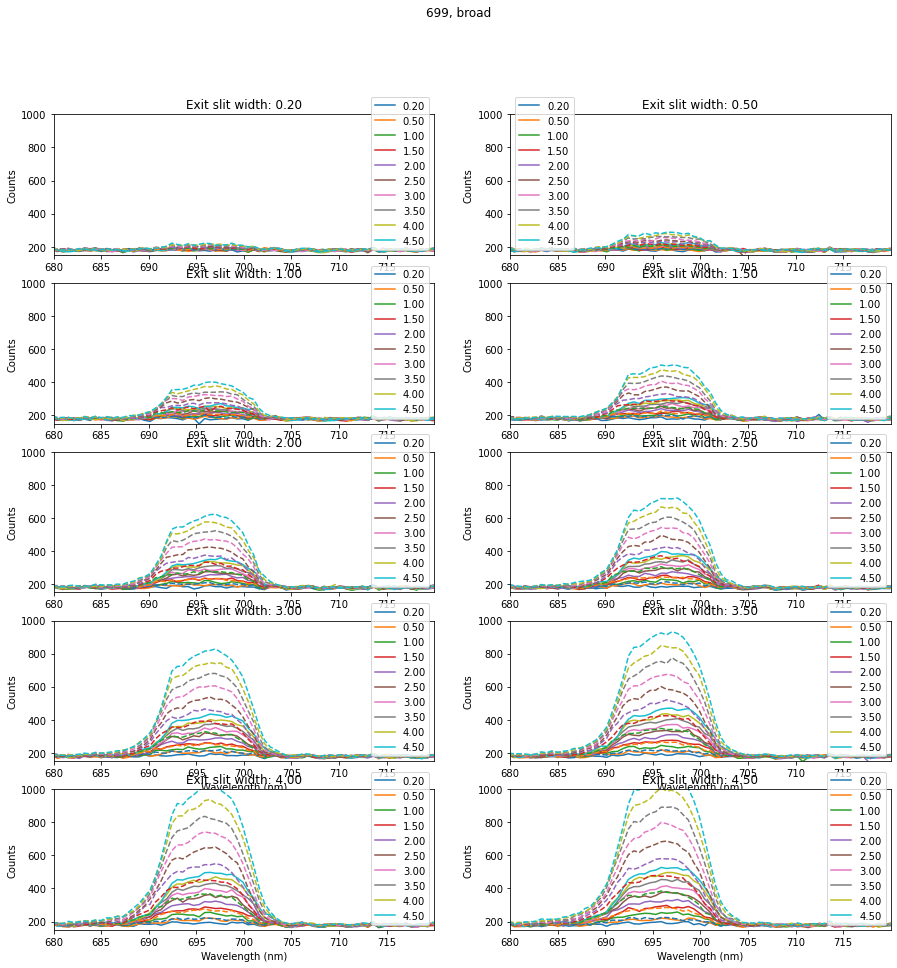

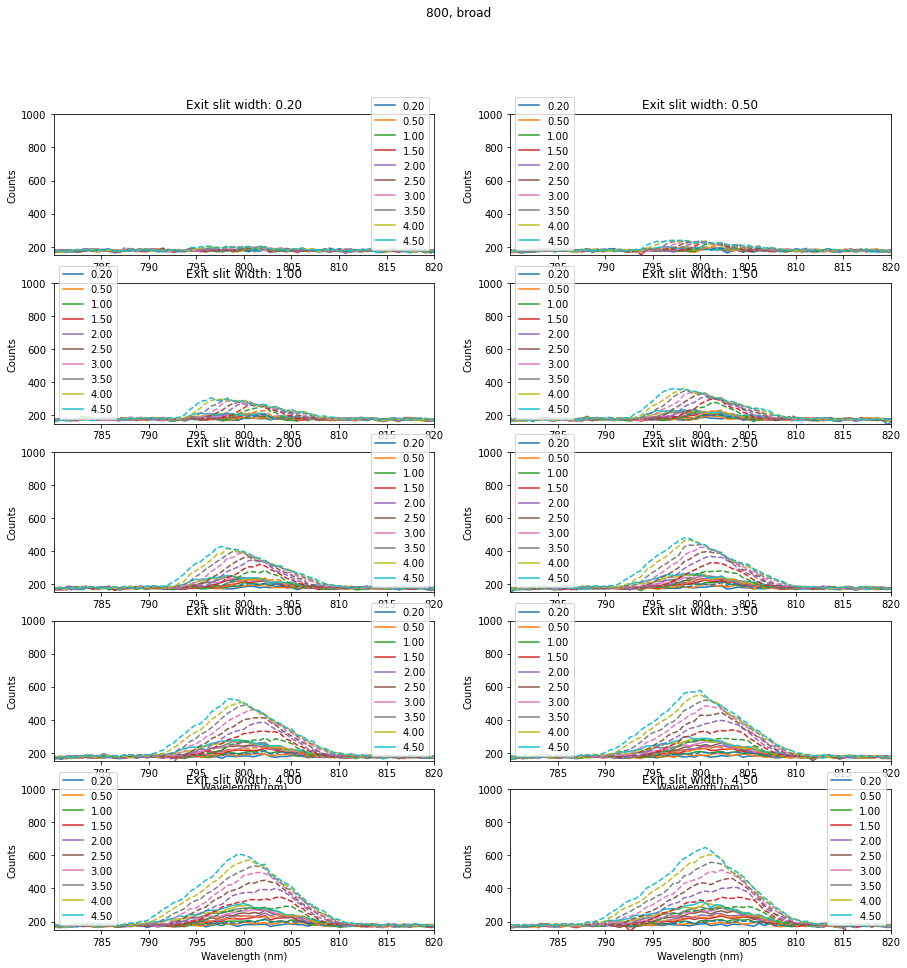

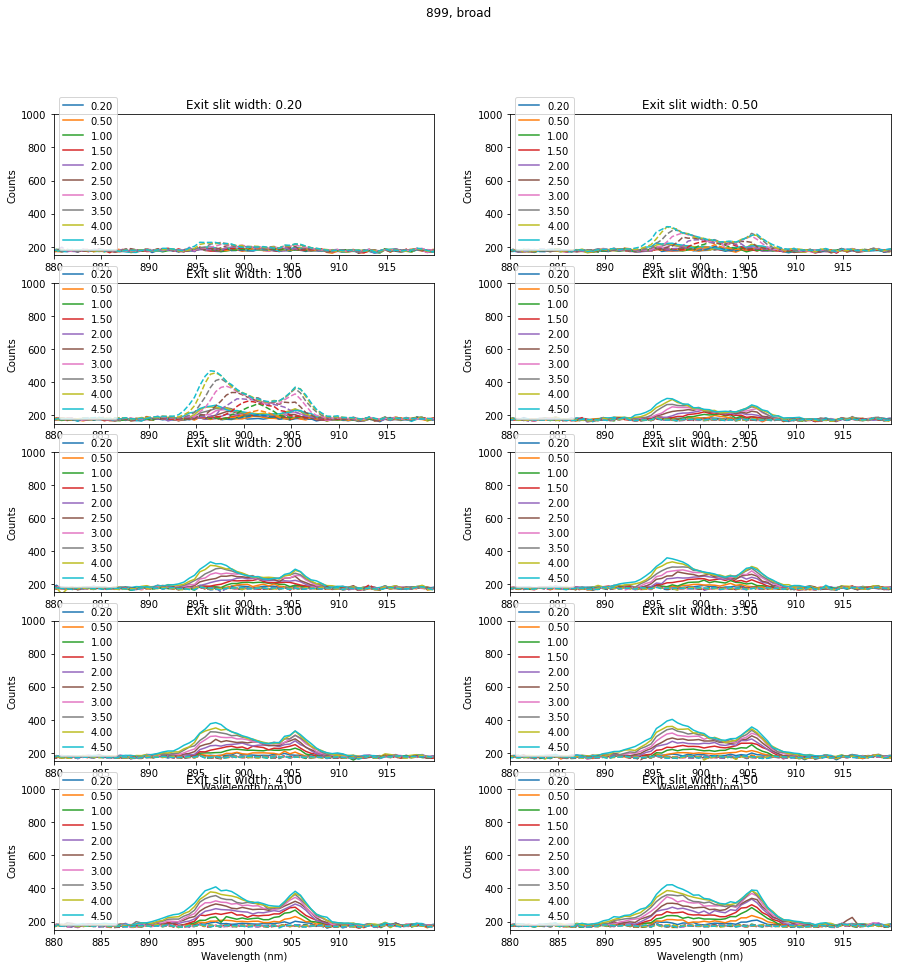

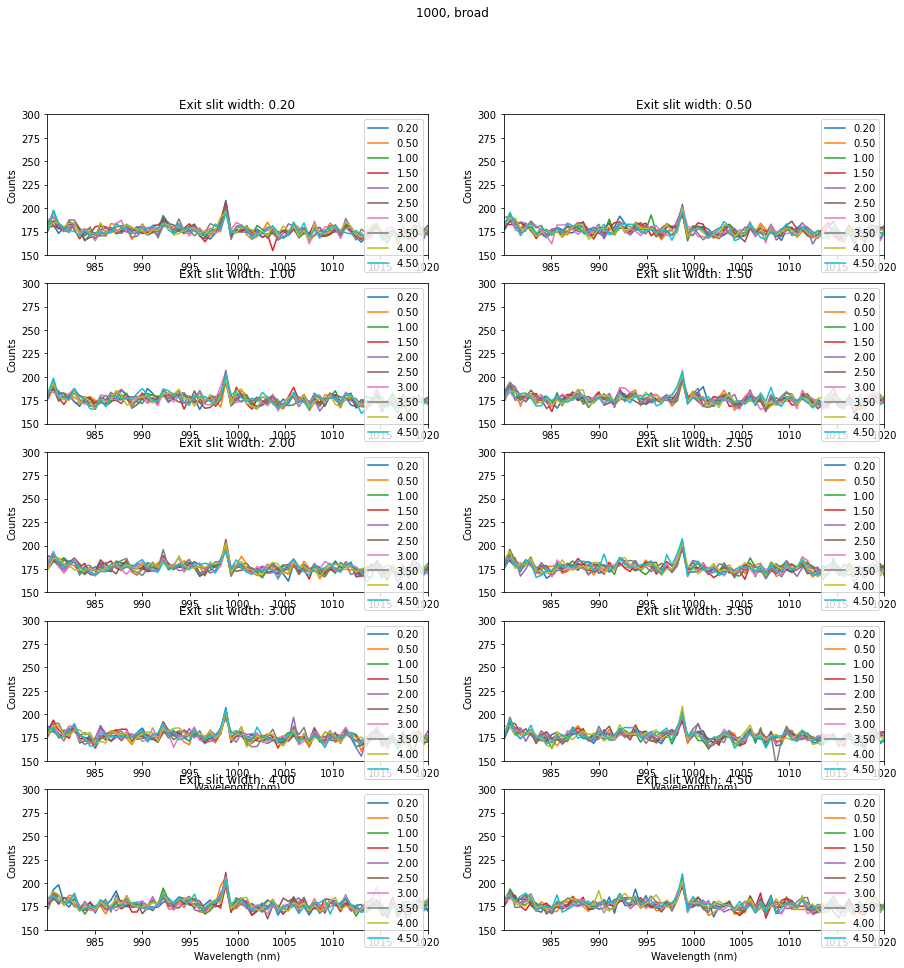

In [12]:
for row in files[0]:
    try:
        plot_slit_width(row[0], row[1])
    except:
        pass

In [14]:
import astropy.table
wave_table = astropy.table.QTable.read(hdu[1])

In [17]:
wave_table['wavelength'].flatten()

<Quantity [ 277.1413269 ,  277.73861694,  278.33584595, ..., 1415.45703125,
           1415.96179199, 1416.46643066] nm>

In [20]:
df_ = df[np.abs(df.entry-0.2)<0.1]

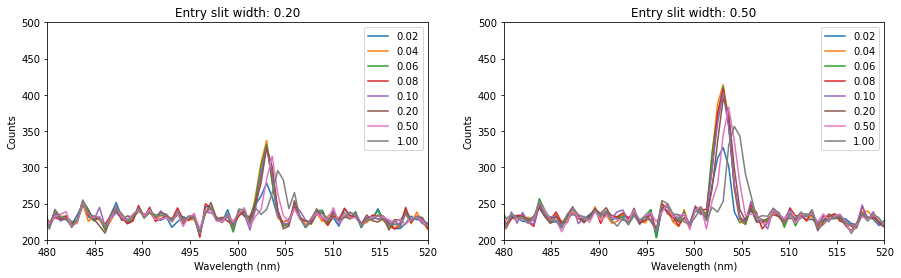

In [10]:
fig, axarr = plt.subplots(1,2, figsize=(15,4))
ax = axarr.ravel()
for i, n in enumerate([0.2, 0.5]):
    data_ = df[np.abs(df.entry-n)<0.1]
    for x,d in data_.iterrows():
        fs_file = os.path.join('/home/parfa30/DATA/fiberSpec_files', d['file'])
        hdu = fits.open(fs_file)
        xx = hdu[1].data['wavelength'][0].flatten()
        ax[i].plot(xx, hdu[0].data, label = '{:.2f}'.format(d['exit']))
    ax[i].set_title('Entry slit width: {:.2f}'.format(np.unique(data_.entry)[0]))
    ax[i].set_xlim(480, 520)
    ax[i].set_ylim(200, 500)
    ax[i].legend()
    ax[i].set_xlabel("Wavelength (nm)")
    ax[i].set_ylabel("Counts")
    

## Test 2: Stability

In [34]:
df = pd.read_csv('/home/parfa30/DATA/AT_stability_500.csv')

In [35]:
hdu = fits.open('/home/parfa30/DATA/AuxTel/wls_stability_900W.fits')

In [49]:
hdu = fits.open('/home/parfa30/DATA/AuxTel/wls_stability_1100W_700nm_2022-09-28T18:24:07.083.fits')

In [56]:
hdu[1].data.exit

array([0.99540001, 0.99540001, 0.99540001, 0.99540001, 0.99540001,
       0.99540001, 0.99540001, 0.99540001, 0.99540001, 0.99540001,
       0.99540001, 0.99540001, 0.99540001, 0.99540001, 0.99540001,
       0.99540001, 0.99540001, 0.99540001, 0.99540001, 0.99540001,
       0.99540001, 0.99540001, 0.99540001, 0.99540001, 0.99540001])

In [10]:
hdu[4].data['Wavelength'].flatten()

array([ 277.1413269 ,  277.73861694,  278.33584595, ..., 1415.45703125,
       1415.96179199, 1416.46643066])

Text(0.5, 1.0, '700nm with 1mm slits')

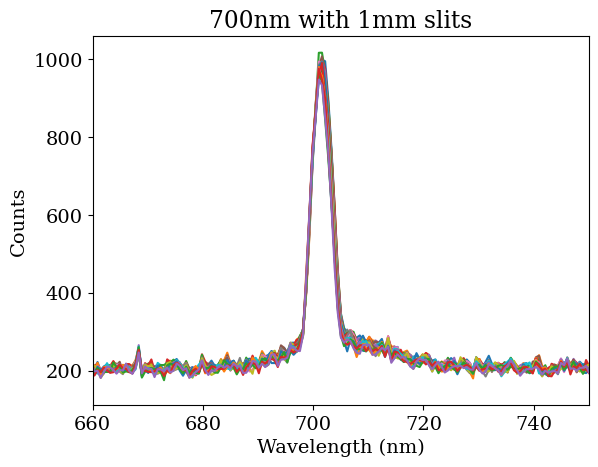

In [58]:
wave = hdu[4].data['Wavelength'].flatten()
for row in hdu[3].data:
    plt.plot(wave, row)
#plt.title('Entry slit width: {:.2f}, Exit slit width: {:.2f}'.format(d['entry'],d['exp_time']))#plt.xlim(695, 710)
#plt.ylim(200, 350)
plt.xlim(660,750)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Counts")
plt.title('700nm with 1mm slits')

In [37]:

for x,d in df.iterrows():
    fs_file = os.path.join('/home/parfa30/DATA/fiberSpec_files', d['file'])
    #hdu = fits.open(fs_file)
    xx = [float(x) for x in hdu[1].data['wavelength'][0]]
    plt.plot(xx, hdu[0].data)
plt.title('Entry slit width: {:.2f}, Exit slit width: {:.2f}'.format(d['entry'],d['exp_time']))
plt.xlim(495, 510)
plt.ylim(200, 350)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Counts")

TypeError: 'numpy.float64' object is not iterable

In [16]:
def gaussian(x, a, b, sigma, c):
    val = a * np.exp(-(x - b)**2 / (2*sigma**2)) + c
    return val

In [17]:
for x,d in df.iterrows():
    fs_file = os.path.join('/home/parfa30/DATA/fiberSpec_files', d['file'])
    hdu = fits.open(fs_file)
    xx = [float(x) for x in hdu[1].data['wavelength'][0]]

In [18]:
fit_data = []
for n, d in df.iterrows():
    fs_file = os.path.join('/home/parfa30/DATA/fiberSpec_files', d['file'])
    hdu = fits.open(fs_file)
    xx = [float(x) for x in hdu[1].data['wavelength'][0]]
    idx = np.where((np.array(xx)>480)&(np.array(xx)<520))
    yyy = hdu[0].data[idx]
    xxx = np.array(xx)[idx]
    popt, pcov = curve_fit(gaussian, xxx, yyy,p0=[1,504,0.1,220])
    if popt[1] < 0:
        popt, pcov = curve_fit(gaussian, xxx, yyy,p0=[1,503,0.1,220])
    fit_data.append([popt[0], popt[1], popt[2], popt[3], n])
    #plt.plot(xx, hdu[0].data, label = '{:.2f}'.format(d['exit']))
    #plt.plot(xxx, gaussian(xxx, *popt))
fit_df = pd.DataFrame(fit_data, columns=['a','wave','sigma','y_offset','index'])

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-3.0.0/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [19]:
outliers = fit_df[fit_df.wave < 0]

In [20]:
outliers.head()

Empty DataFrame
Columns: [a, wave, sigma, y_offset, index]
Index: []

(200.0, 350.0)

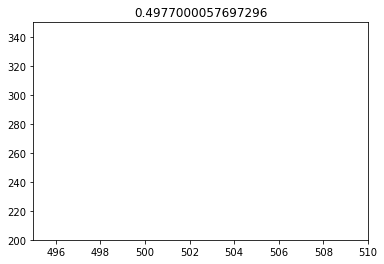

In [107]:
for x,row in outliers.iterrows():
    d = df.iloc[int(row['index'])]
    fs_file = os.path.join('/home/parfa30/DATA/fiberSpec_files', d['file'])
    hdu = fits.open(fs_file)
    xx = [float(x) for x in hdu[1].data['wavelength'][0]]
    plt.plot(xx, hdu[0].data, label = '{:.2f}'.format(d['exit']),alpha=0.5)
    idx = np.where((np.array(xx)>480)&(np.array(xx)<520))
    yyy = hdu[0].data[idx]
    xxx = np.array(xx)[idx]
    popt, pcov = curve_fit(gaussian, xxx, yyy,p0=[1,503,0.1,220])
    fit_data.append([popt[0], popt[1], popt[2], popt[3], n])
    plt.plot(xxx, gaussian(xxx,*popt), '--')
plt.title(np.unique(data_.entry)[0])
plt.xlim(495, 510)
plt.ylim(200, 350)

In [108]:
fit_df = fit_df[fit_df.wave >0]
len(fit_df)

25

In [27]:
print(np.mean(fit_df.wave))

503.53088989368393


Text(0.5, 0, 'sigma')

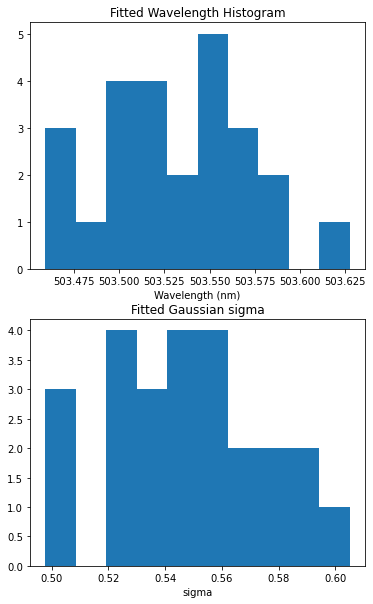

In [23]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(6,10))
ret = ax1.hist(fit_df.wave)
ax1.set_title("Fitted Wavelength Histogram")
ax1.set_xlabel("Wavelength (nm)")

ret = ax2.hist(fit_df.sigma)
ax2.set_title("Fitted Gaussian sigma")
ax2.set_xlabel("sigma")

(array([3., 0., 4., 3., 4., 4., 2., 2., 2., 1.]),
 array([0.49775004, 0.50848563, 0.51922121, 0.52995679, 0.54069237,
        0.55142795, 0.56216354, 0.57289912, 0.5836347 , 0.59437028,
        0.60510587]),
 <BarContainer object of 10 artists>)

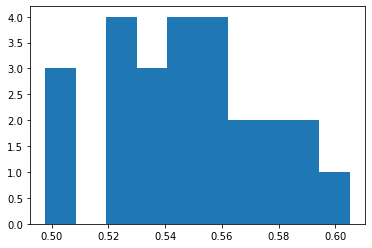

In [110]:
plt.hist(fit_df.sigma)

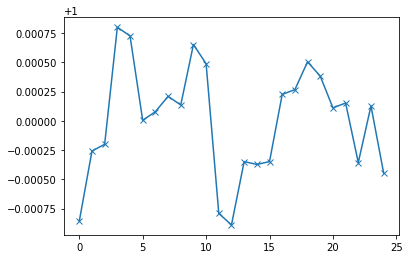

In [73]:
plt.plot(df.index, df.elec_mean*-1/np.mean(df.elec_mean*-1), 'x-')

Text(0, 0.5, 'Amps')

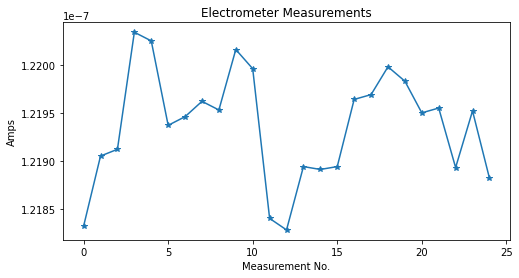

In [26]:
plt.figure(figsize=(8,4))
plt.title("Electrometer Measurements")
plt.plot(df.index, df.elec_mean*-1,'*-')
plt.xlabel("Measurement No.")
plt.ylabel("Amps")

## Test 3: WLS Power

In [28]:
filen = 'wls_power_stability_1000W_500nm_2022-09-27.csv'
df = pd.read_csv(filen)

In [9]:
df.head()

Unnamed: 0                              time          mean        median  \
0           0  2022-09-27 20:28:41.383530+00:00 -4.647780e-11 -4.746200e-11   
1           1  2022-09-27 20:29:42.615243+00:00 -4.596250e-03 -4.582050e-03   
2           2  2022-09-27 20:30:43.850457+00:00 -4.699810e-03 -4.694750e-03   
3           3  2022-09-27 20:31:45.087123+00:00 -4.705330e-03 -4.704450e-03   
4           4  2022-09-27 20:32:46.322313+00:00 -4.660050e-03 -4.662650e-03   

            std  
0  3.847670e-12  
1  2.743540e-05  
2  2.320580e-05  
3  2.628290e-05  
4  2.808360e-05

Text(0.5, 1.0, 'WLS power: 1000W; 500nm; slits @ 4.5mm')

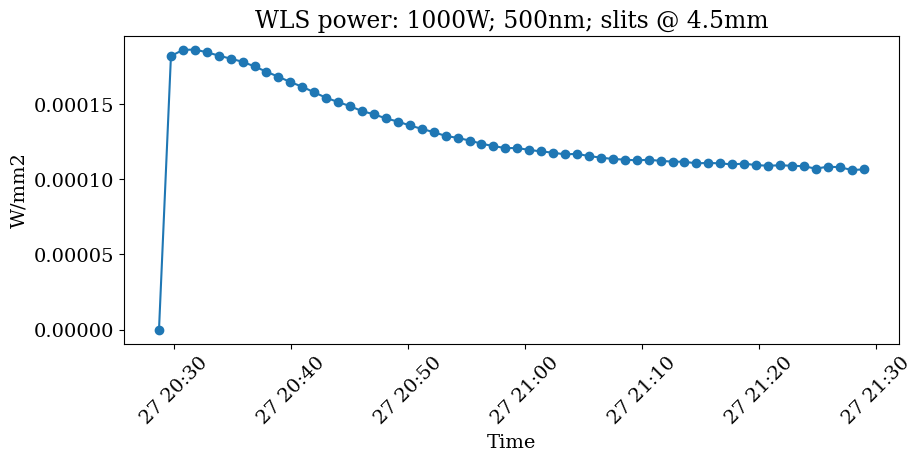

In [30]:
plt.figure(figsize=(10,4))
plt.plot(pd.to_datetime(df['time']),watts_per_mm2(df['mean']*-1, 500), 'o-')
plt.xticks(rotation=45)
plt.xlabel('Time')
plt.ylabel('W/mm2')
plt.title('WLS power: 1000W; 500nm; slits @ 4.5mm')

In [35]:
hdu[2].data.dtype

dtype((numpy.record, [('start', 'S23'), ('end', 'S23'), ('filen', 'S41'), ('mean', '>f8'), ('median', '>f8'), ('std', '>f8')]))

In [32]:
filen1 = 'wls_power_variation_quick_grating0_2022-09-27.fits'
filen2 = 'wls_power_variation_quick2_grating0_2022-09-27.fits'
filen3 = 'wls_power_variation_quick3_grating0_2022-09-27.fits'

In [33]:
hdu = fits.open(os.path.join(data_dir, filen1))
hdu2 = fits.open(os.path.join(data_dir, filen2))
hdu3 = fits.open(os.path.join(data_dir, filen3))

In [38]:
hdu[1].data

FITS_rec([('2022-09-27T18:12:40.197', '2022-09-27T18:12:46.379',  800, 1., 500.00009155, 4.49826002, 4.49826002, 0),
          ('2022-09-27T18:12:46.380', '2022-09-27T18:12:52.624',  900, 1., 500.00009155, 4.49826002, 4.49826002, 0),
          ('2022-09-27T18:12:52.625', '2022-09-27T18:12:58.869', 1000, 1., 500.00009155, 4.49826002, 4.49826002, 0),
          ('2022-09-27T18:12:58.869', '2022-09-27T18:13:05.115', 1100, 1., 500.00009155, 4.49826002, 4.49826002, 0),
          ('2022-09-27T18:13:05.116', '2022-09-27T18:13:11.366', 1200, 1., 500.00009155, 4.49826002, 4.49826002, 0)],
         dtype=(numpy.record, [('start', 'S23'), ('end', 'S23'), ('wls_power', '>i8'), ('exptime', '>f8'), ('wavelength', '>f8'), ('entry', '>f8'), ('exit', '>f8'), ('grating', '>i8')]))

Text(0.5, 1.0, 'WLS Power vs output [500nm, grating 0, slits @ 4.5mm]')

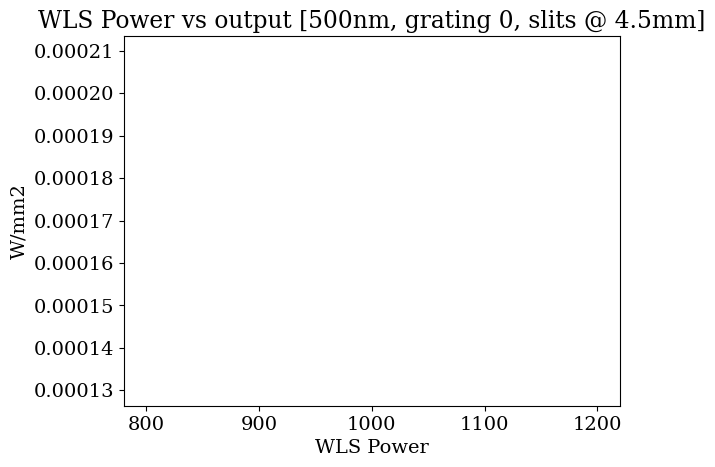

In [35]:
  
for i, x in enumerate(hdu[1].data):
    plt.plot(x['wls_power'], watts_per_mm2(hdu[2].data[i]['mean']*-1, 500))
plt.xlabel('WLS Power')
plt.ylabel('W/mm2')
plt.title('WLS Power vs output [500nm, grating 0, slits @ 4.5mm]')

In [17]:
filen = 'wls_power_variation_grating0_2022-09-27.fits'
hdu = fits.open(os.path.join(data_dir, filen))

In [18]:
hdu[1].data

FITS_rec([('2022-09-27T18:24:17.630', '2022-09-27T18:24:23.863',  800, 1.,  300.00079346, 4.49826002, 4.49826002, 0),
          ('2022-09-27T18:24:25.759', '2022-09-27T18:24:31.994',  800, 1.,  400.00061035, 4.49826002, 4.49826002, 0),
          ('2022-09-27T18:24:33.894', '2022-09-27T18:24:40.120',  800, 1.,  500.00009155, 4.49826002, 4.49826002, 0),
          ('2022-09-27T18:24:42.017', '2022-09-27T18:24:48.249',  800, 1.,  599.99932861, 4.49826002, 4.49826002, 0),
          ('2022-09-27T18:24:50.204', '2022-09-27T18:24:56.440',  800, 1.,  699.99957275, 4.49826002, 4.49826002, 0),
          ('2022-09-27T18:24:58.900', '2022-09-27T18:25:05.133',  800, 1.,  799.99957275, 4.49826002, 4.49826002, 0),
          ('2022-09-27T18:25:07.594', '2022-09-27T18:25:13.827',  800, 1.,  899.99908447, 4.49826002, 4.49826002, 0),
          ('2022-09-27T18:25:16.287', '2022-09-27T18:25:22.520',  800, 1., 1000.00061035, 4.49826002, 4.49826002, 0),
          ('2022-09-27T18:25:24.980', '2022-09-27T18:25:

500.0000915527344 0.010600433527074305
500.0000915527344 0.011771935434951081
500.0000915527344 0.01325933104671451
500.0000915527344 0.014778989829740642
500.0000915527344 0.015512402263456914


Text(0, 0.5, 'W/mm2')

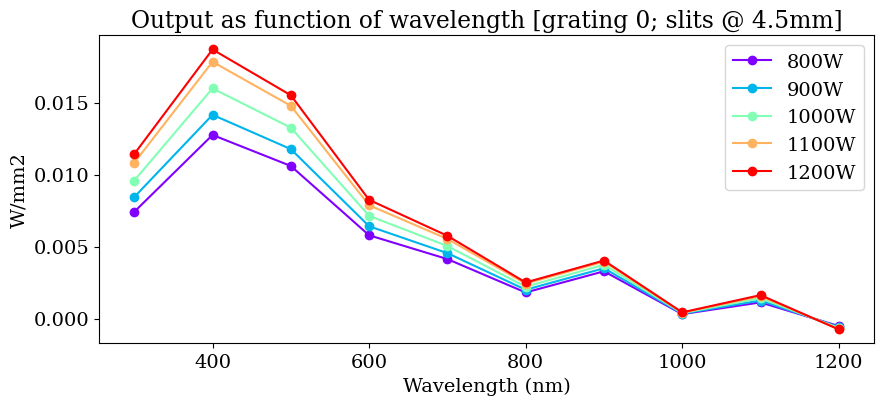

In [21]:
config = hdu[1].data 
powers = np.unique(config.wls_power)
colors = cm.rainbow(np.linspace(0, 1, len(powers)))
plt.figure(figsize=(10,4))
for c, power in enumerate(powers):

    elec = hdu[2].data

    config_idx = np.where((config['wls_power'] == power))
    waves = []
    data = []
    for idx in config_idx:
        w = config[idx]['wavelength']
        for ii, ww in enumerate(w):
            
            waves.append(ww)
            d = watts_per_cm2(elec[idx]['mean'][ii]*-1, float(ww))
            if np.abs(ww-500) < 1:
                print(ww, d)
            data.append(d)
    plt.plot(waves, data,'o-',color = colors[c], label='{}W'.format(power))
plt.legend()
plt.title('Output as function of wavelength [grating 0; slits @ 4.5mm]')
plt.xlabel('Wavelength (nm)')
plt.ylabel('W/mm2')

In [16]:
data_dir = '/home/parfa30/DATA/AuxTel'
files = ['wls_power_variation_grating1_2022-09-22.fits',
        'wls_power_variation_grating0_2022-09-23.fits']


In [5]:
hdu = fits.open(os.path.join(data_dir, files[0]))
hdu.info()

Filename: /home/parfa30/DATA/AuxTel/wls_power_variation_grating1_2022-09-22.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  CONFIG        1 BinTableHDU     25   200R x 8C   [23A, 23A, K, D, D, D, D, K]   
  2  KEITHLEY      1 BinTableHDU     21   200R x 6C   [23A, 23A, 42A, D, D, D]   


In [6]:
hdu[1].data.dtype

dtype((numpy.record, [('start', 'S23'), ('end', 'S23'), ('wls_power', '>i8'), ('exptime', '>f8'), ('wavelength', '>f8'), ('entry', '>f8'), ('exit', '>f8'), ('grating', '>i8')]))

In [54]:
from astropy.table import Table

In [6]:
hdus = []
for filen in files:
    p = os.path.splitext(filen)[0].split('_')
    for pp in p:
        if 'W' in pp:
            power = int(pp.replace('W',''))
    hdu = fits.open(os.path.join(data_dir, filen))
    hdus.append(hdu)

In [79]:
hdus[0][1].data

FITS_rec([],
         dtype=(numpy.record, [('start', '>f8'), ('end', '>f8'), ('wls_power', '>f8'), ('exptime', '>f8'), ('wavelength', '>f8'), ('entry', '>f8'), ('exit', '>f8'), ('grating', '>f8')]))

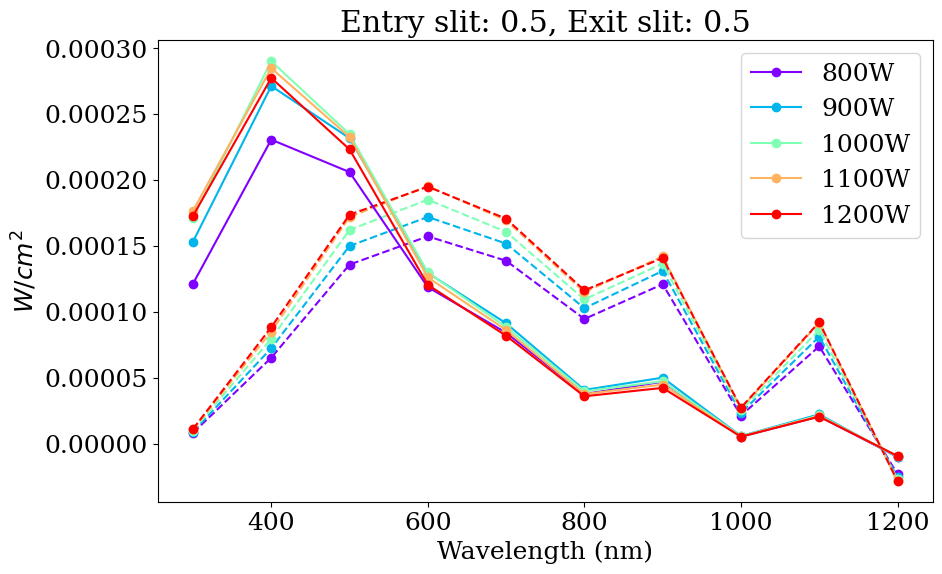

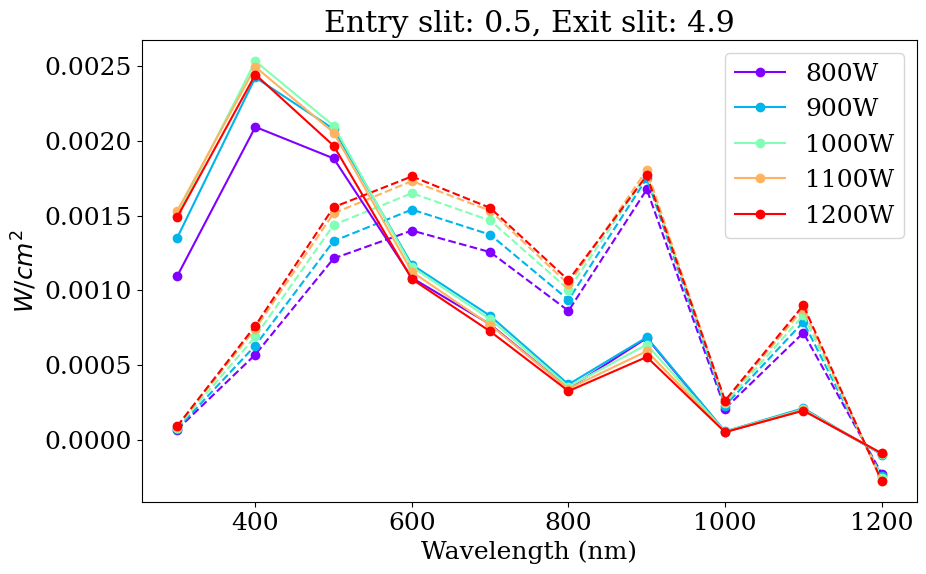

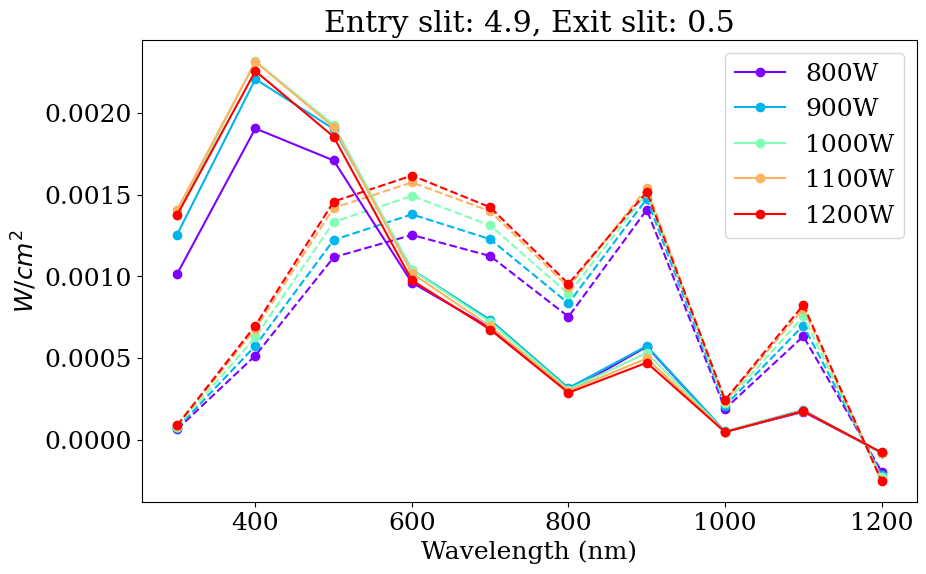

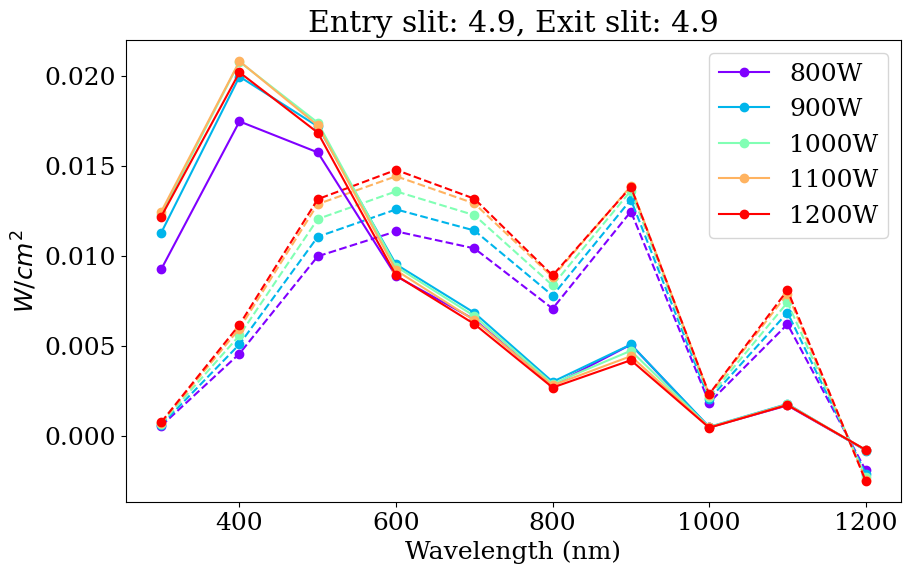

In [8]:

colors = cm.rainbow(np.linspace(0, 1, len(hdus)))

for entry_slit in [0.5, 4.9]:
    for exit_slit in [0.5, 4.9]:
        plt.figure(figsize=(10,6))
        for hdu in hdus:
            
            config = hdu[1].data
            
            powers = np.unique(config.wls_power)
            colors = cm.rainbow(np.linspace(0, 1, len(powers)))
            for c, power in enumerate(powers):

                elec = hdu[2].data

                for grating in np.unique(config['grating']):
                    config_idx = np.where((config['wls_power'] == power)&((np.abs(config['entry']-entry_slit))<1)&(np.abs(config['exit']-exit_slit)<1))
                    waves = []
                    data = []
                    for idx in config_idx:
                        w = config[idx]['wavelength']
                        for ii, ww in enumerate(w):
                            waves.append(ww)
                            d = watts_per_cm2(elec[idx]['mean'][ii], float(ww))*-1
                            data.append(d)

                    if grating == 0:
                        plt.plot(waves, data,'o-',color = colors[c], label='{}W'.format(power))
                    elif grating == 1:
                        plt.plot(waves, data,'o--',color = colors[c])
        plt.legend()
        plt.xlabel('Wavelength (nm)')
        plt.ylabel('$W/cm^{2}$')
        plt.title('Entry slit: {}, Exit slit: {}'.format(entry_slit, exit_slit))

## Test 4

In [36]:
filen = 'wls_power_stability_1100W_2022-09-23.fits'

In [37]:
hdu = fits.open(os.path.join(data_dir, filen))

In [25]:
config = hdu[1].data

In [35]:
np.unique(config.grating)

array([0])

In [27]:
ii = np.array([1,2,3,4])

In [28]:
config[ii]

FITS_rec([('2022-09-22T18:08:19.594', '2022-09-22T18:08:31.461', 800, 1., 299.99960327, 0.49770001, 4.89642   , 1),
          ('2022-09-22T18:08:31.462', '2022-09-22T18:08:46.468', 800, 1., 299.99960327, 4.89642   , 0.49770001, 1),
          ('2022-09-22T18:08:46.468', '2022-09-22T18:08:58.332', 800, 1., 299.99960327, 4.89642   , 4.89642   , 1),
          ('2022-09-22T18:08:58.333', '2022-09-22T18:09:14.593', 800, 1., 400.00061035, 0.49770001, 0.49770001, 1)],
         dtype=(numpy.record, [('start', 'S23'), ('end', 'S23'), ('wls_power', '>i8'), ('exptime', '>f8'), ('wavelength', '>f8'), ('entry', '>f8'), ('exit', '>f8'), ('grating', '>i8')]))

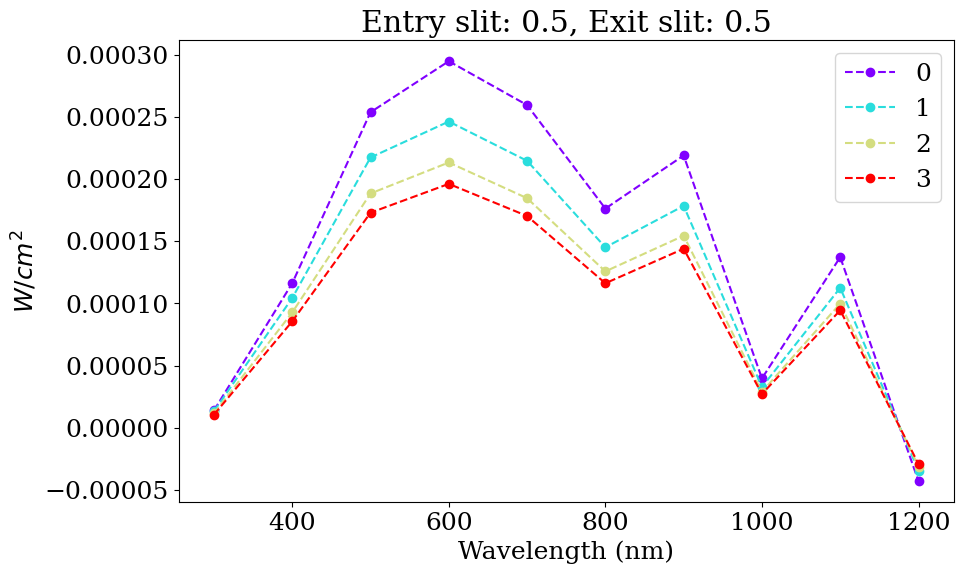

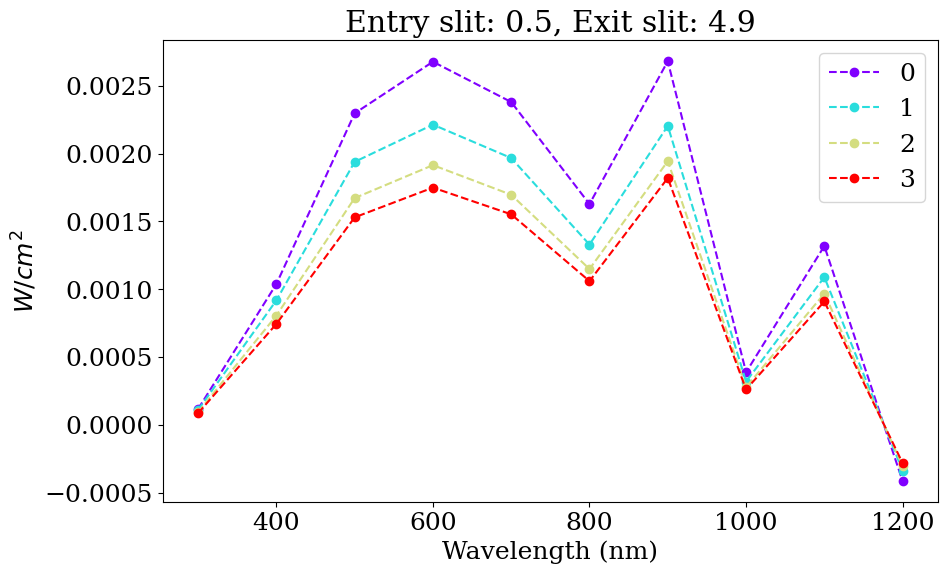

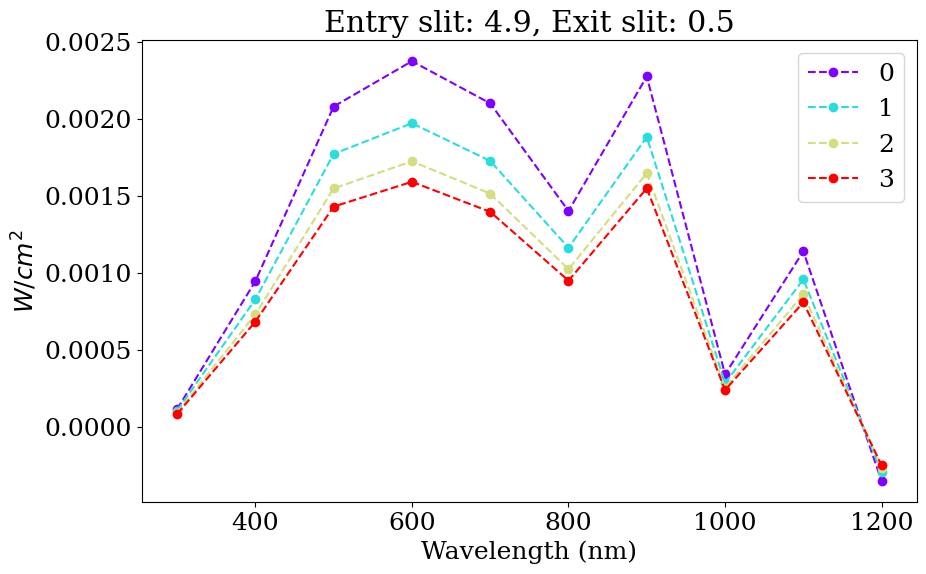

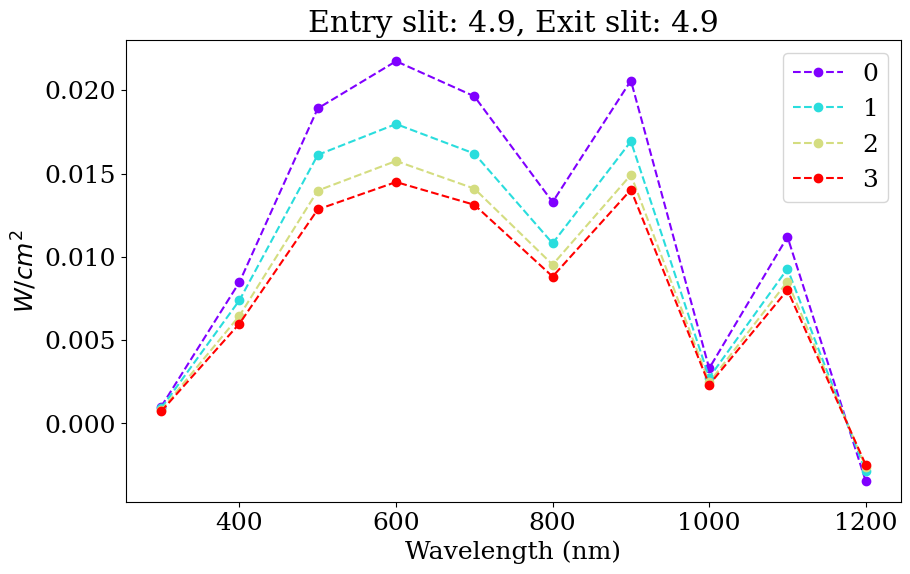

In [40]:
from matplotlib.pyplot import cm

for entry_slit in [0.5, 4.9]:
    for exit_slit in [0.5, 4.9]:
        plt.figure(figsize=(10,6))

        config = hdu[1].data

        colors = cm.rainbow(np.linspace(0, 1, 4))
        for c, i in enumerate(range(4)):
            idx = np.linspace(i*40, i*40+39, 40,dtype=int)
            elec = hdu[2].data
            this_config = config[np.array(idx)]
            this_elec = elec[np.array(idx)]
            config_idx = np.where(((np.abs(this_config['entry']-entry_slit))<1)&(np.abs(this_config['exit']-exit_slit)<1))
            waves = []
            data = []
            for idx_ in config_idx:
                w = this_config[idx_]['wavelength']
                for ii, ww in enumerate(w):
                    waves.append(ww)
                    d = watts_per_cm2(this_elec[idx_]['mean'][ii], float(ww))*-1
                    data.append(d)

                ii_ = np.argsort(waves)
                plt.plot(np.array(waves)[ii_], np.array(data)[ii_],'o--',color = colors[c], label=c)
                    
        plt.legend()
        plt.xlabel('Wavelength (nm)')
        plt.ylabel('$W/cm^{2}$')
        plt.title('Entry slit: {}, Exit slit: {}'.format(entry_slit, exit_slit))